<a href="https://colab.research.google.com/github/ElizabethCherrie/Analysis/blob/main/Data_Analisys_Project_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Missing semester 57.

## Итоговый проект

[источник](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/homeworks-practice/homework-practice-02-linregr.ipynb) части задач

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и проверим несколько статистических гипотез.


В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
#!pip install folium

In [3]:
import folium

f = folium.Figure(width=1000, height=500)
m = folium.Map(location=(55.7522200, 37.6155600), tiles="cartodb positron", zoom_start = 10).add_to(f)

political_countries_url = (
    "http://geojson.xyz/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson"
)
#folium.GeoJson(political_countries_url).add_to(m)
m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

## Часть 0. Подготовка


**Задание 1**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку (train.csv) из этого соревнования и загрузите ее:

In [6]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [7]:
df = pd.read_csv("train.csv") #- так можно запускать, если вы скачаете
#  датасет и положите его в папку "Файлы" в колабе
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. Там записаны дата и время начала и конца поездки. Чтобы с ними было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [8]:
import datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
# тут подсазка как это сделать
# source: https://www.delftstack.com/howto/python-pandas/how-to-convert-dataframe-column-to-datetime-in-pandas/#pandas-to_datetime-pd.to_datetime-function-to-convert-dataframe-column-to-pandas-datetime

In [9]:
#проверьте, что всё правильно преобразовалось
df.dtypes

,0
id,object
vendor_id,int64
pickup_datetime,datetime64[ns]
dropoff_datetime,datetime64[ns]
passenger_count,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
store_and_fwd_flag,object


В колонке `trip_duration` записана длина поезки в секундах. Давайте посмотрим на её распределение. Для этого нарисуйте его гистограмму:

Что получается, если не задавать конкретный диапозон значений? Почему так?


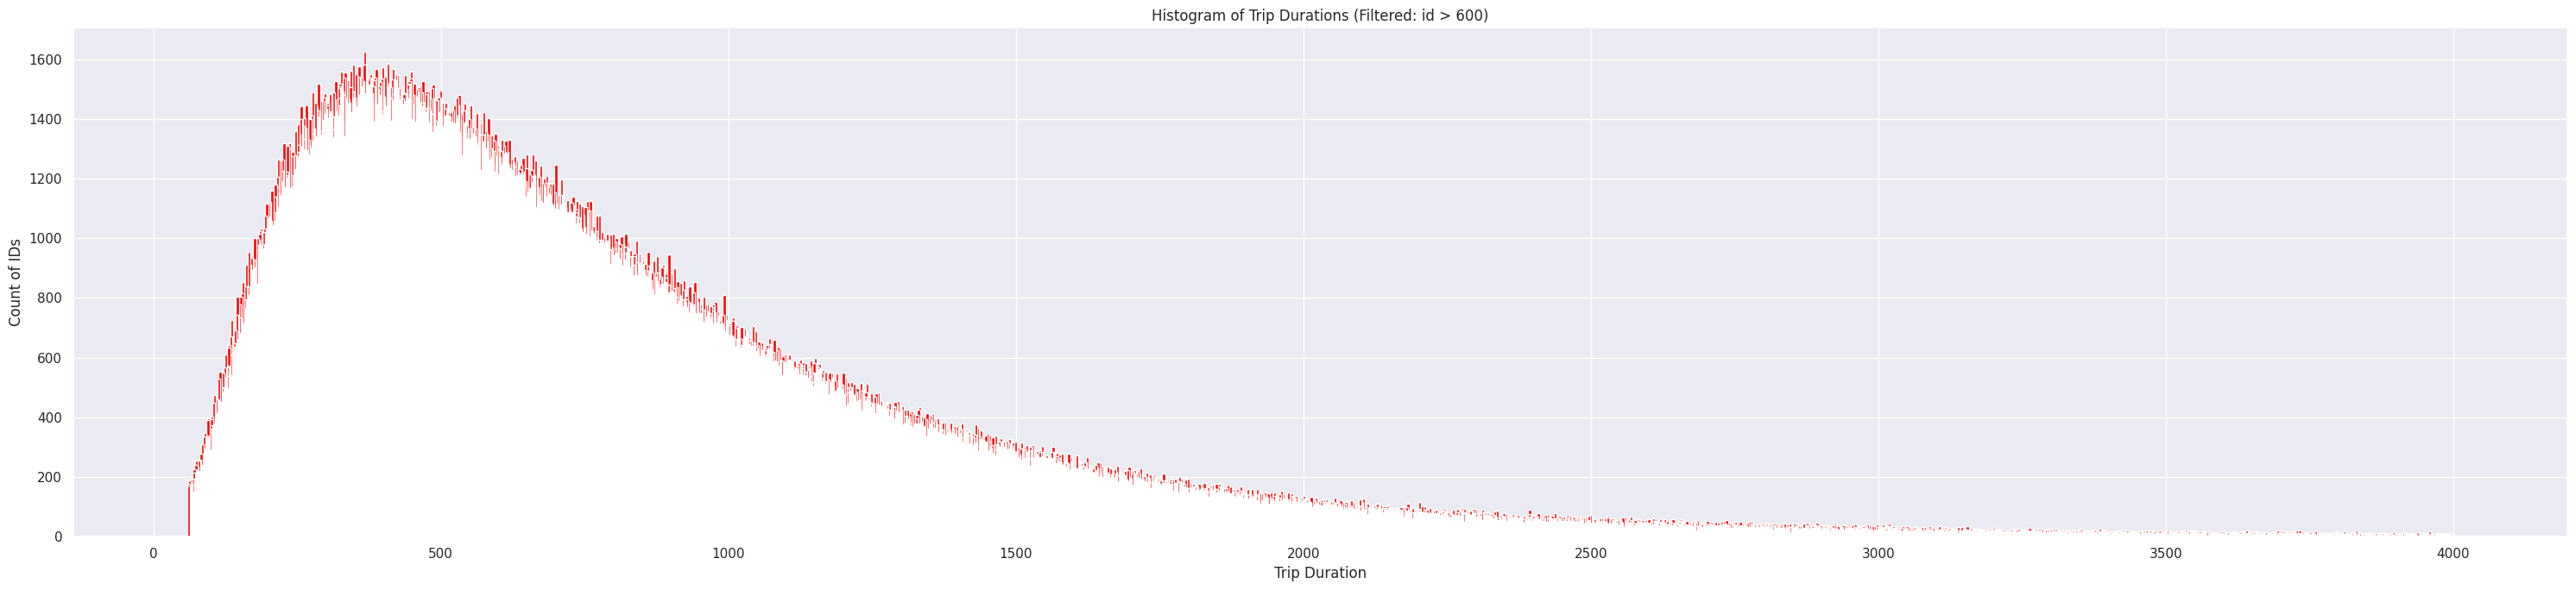

In [17]:
group = df[['id', 'trip_duration']].groupby('trip_duration', as_index=False).count().sort_values(by='trip_duration', ascending= False)
group = group[(group['trip_duration'] > 60) & (group['trip_duration'] < 4000)]
plt.figure(figsize=(30, 7))
plt.bar(group['trip_duration'], group['id'], color='red', width = 5)
plt.xlabel('Trip Duration')
plt.ylabel('Count of IDs')
plt.title('Histogram of Trip Durations (Filtered: id > 600)')
plt.tight_layout()
plt.show()

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

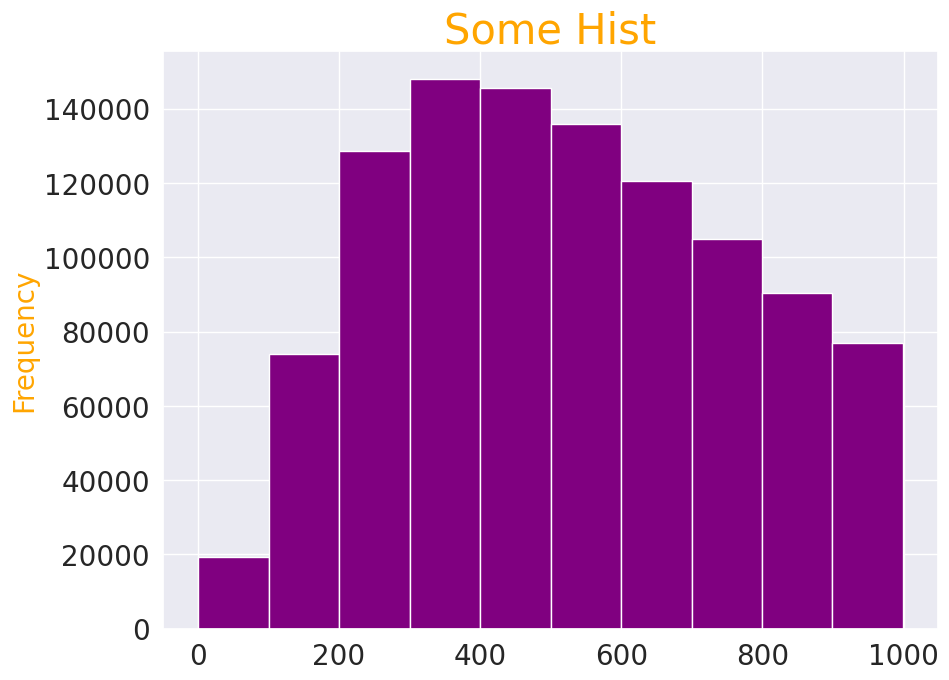

In [18]:
plt.figure(figsize = (10, 7.5))
plt.ylabel('ylabel', fontsize=20, color = "orange")
plt.title("Some Hist", fontsize=30, color = "orange")
plt.yticks(rotation=0)
df[df["trip_duration"] < 1000]["trip_duration"].plot(kind = "hist", fontsize = 20, rot = 0, color = "purple")
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

## Часть 1. Изучаем `pickup_datetime`

**Задание 2**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

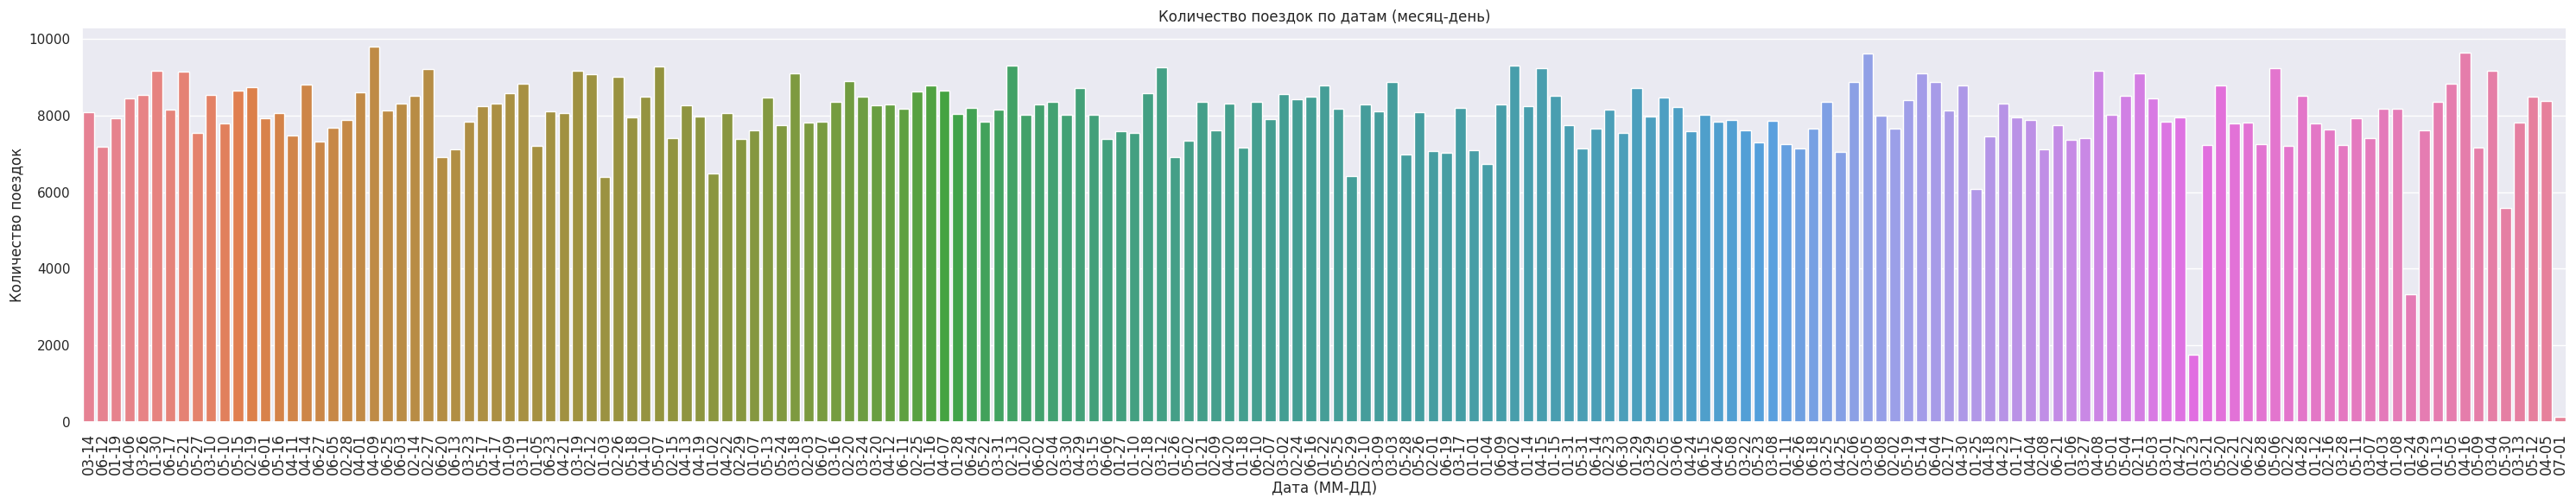

In [20]:
# подсказка тут:
# groupby month, day: https://github.com/pandas-dev/pandas/issues/21075
df['month_day'] = df['dropoff_datetime'].dt.strftime('%m-%d')

plt.figure(figsize=(30, 6))
sns.countplot(data=df, x='month_day', palette='husl')

plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Дата (ММ-ДД)')
plt.ylabel('Количество поездок')
plt.title('Количество поездок по датам (месяц-день)')
plt.tight_layout()
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

23–24 января 2016 года Нью-Йорк пережил историческую метель, ставшую самым значительным снежным штормом в истории города. Шторм, неофициально названный «Winter Storm Jonas», начался 22 января и усилился ночью 23 января. Он принес в восточные штаты США сильный снег, сильный ветер и плохую видимость.

**Задание 3**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

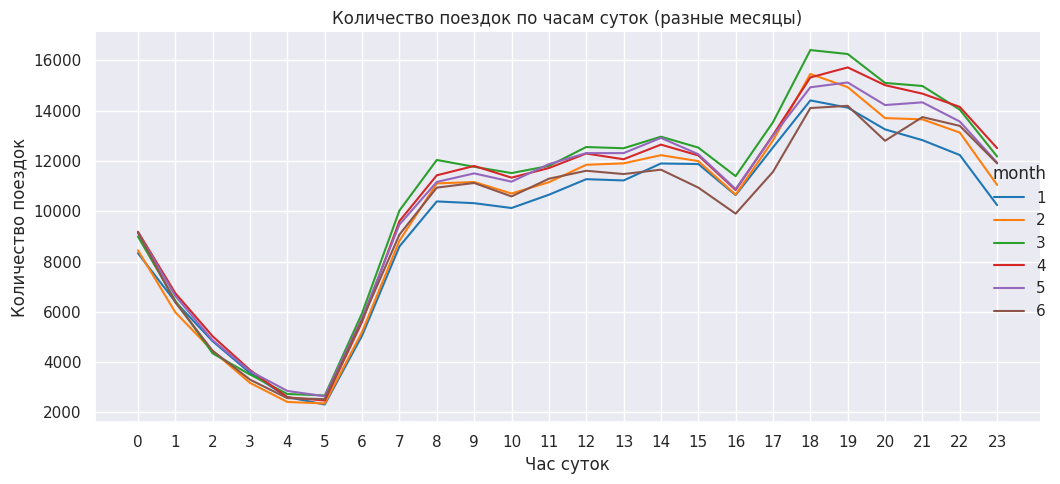

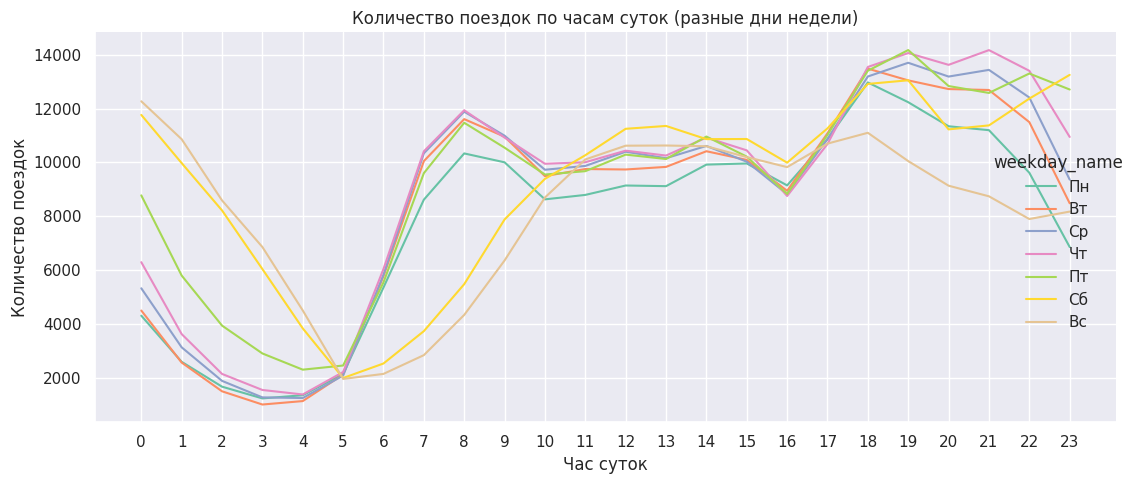

In [23]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

df['hour'] = df['pickup_datetime'].dt.hour
df['month'] = df['pickup_datetime'].dt.month


hour_month = df.groupby(['month', 'hour']).size().reset_index(name='trip_count')

g = sns.relplot(
    data=hour_month,
    x='hour',
    y='trip_count',
    hue='month',
    kind='line',
    height=5,
    aspect=2,
    palette='tab10'
).set(
    title='Количество поездок по часам суток (разные месяцы)',
    xlabel='Час суток',
    ylabel='Количество поездок'
)

g.ax.set_xticks(np.arange(0, 24, 1))

plt.tight_layout()
plt.show()

df['weekday'] = df['dropoff_datetime'].dt.dayofweek

weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
df['weekday_name'] = df['weekday'].map(lambda x: weekday_names[x])

df['weekday_name'] = pd.Categorical(df['weekday_name'], categories=weekday_names, ordered=True)

hour_weekday = df.groupby(['weekday_name', 'hour']).size().reset_index(name='trip_count')

g2 = sns.relplot(
    data=hour_weekday,
    x='hour',
    y='trip_count',
    hue='weekday_name',
    kind='line',
    height=5,
    aspect=2,
    palette='Set2'
).set(
    title='Количество поездок по часам суток (разные дни недели)',
    xlabel='Час суток',
    ylabel='Количество поездок'
)
g2.ax.set_xticks(np.arange(0, 24, 1))

plt.tight_layout()
plt.show()

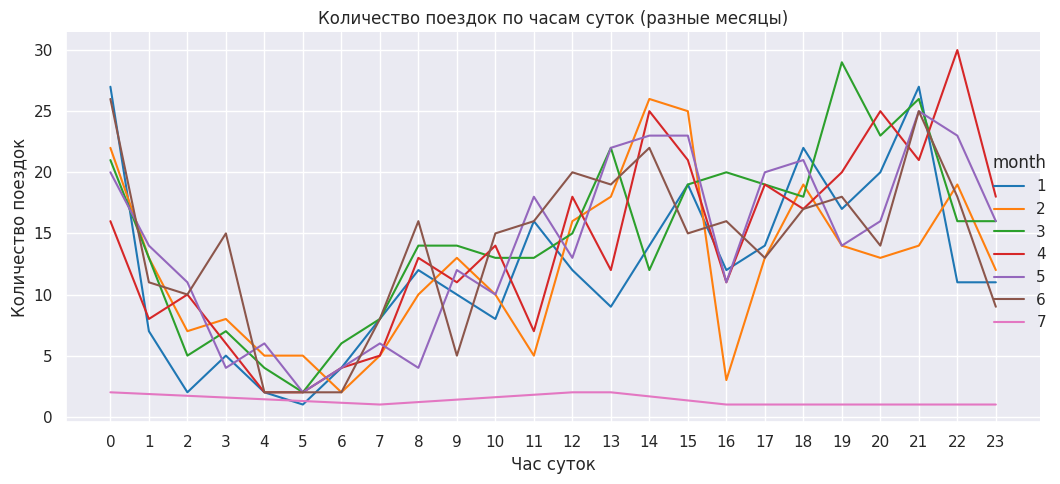

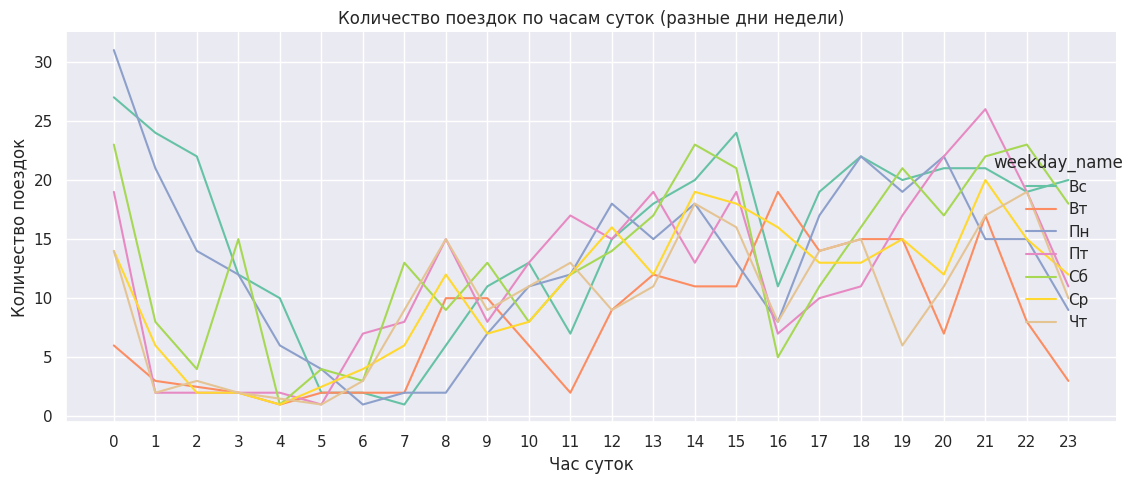

In [24]:
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60

df_filtered = df[df['trip_duration'] >= 1000].copy()

df_filtered['hour'] = df_filtered['dropoff_datetime'].dt.hour
df_filtered['month'] = df_filtered['dropoff_datetime'].dt.month
df_filtered['weekday'] = df_filtered['dropoff_datetime'].dt.dayofweek

weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
df_filtered['weekday_name'] = df_filtered['weekday'].map(lambda x: weekday_names[x])

# Group by month and hour, count trips
hour_month = df_filtered.groupby(['month', 'hour']).size().reset_index(name='trip_count')

# Group by weekday_name and hour, count trips
hour_weekday = df_filtered.groupby(['weekday_name', 'hour']).size().reset_index(name='trip_count')

# Plot trips by hour for different months
g1 = sns.relplot(
    data=hour_month,
    x='hour',
    y='trip_count',
    hue='month',
    kind='line',
    height=5,
    aspect=2,
    palette='tab10'
).set(
    title='Количество поездок по часам суток (разные месяцы)',
    xlabel='Час суток',
    ylabel='Количество поездок'
)

g1.ax.set_xticks(np.arange(0, 24, 1))  # Show all hours on x-axis
plt.tight_layout()
plt.show()

# Plot trips by hour for different weekdays
g2 = sns.relplot(
    data=hour_weekday,
    x='hour',
    y='trip_count',
    hue='weekday_name',
    kind='line',
    height=5,
    aspect=2,
    palette='Set2'
).set(
    title='Количество поездок по часам суток (разные дни недели)',
    xlabel='Час суток',
    ylabel='Количество поездок'
)

g2.ax.set_xticks(np.arange(0, 24, 1))  # Show all hours on x-axis
plt.tight_layout()
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [25]:
df['weekday'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['anomaly_period_1'] = df['pickup_datetime'].isin(pd.to_datetime(['2016-01-23','2016-01-24'])).astype(int)
df['anomaly_period_2'] = ((df['hour'] >= 3) & (df['hour'] <= 6)).astype(int)
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

## Часть 2. Изучаем координаты
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Для вас подготовлена функция, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(data.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(data.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?


**Задание 4**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 5**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 6**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 3. Последняя предобработка

**Задание 7**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки или с очень большим пройденным расстоянием. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 4. Статистика

**Задание 8**. Проверьте гипотезу о том, что длина поездки и число пассажиров -- независимые случайные величины с помощью критерия хи-квадрат

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 9**. Проверьте гипотезу о том, что средняя длина поездки равна 20 минут

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 10**. Проверьте гипотезу о том, что длина поездки равна нормально $N(700, 30000)$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

<img src="https://i.redd.it/ltzsp7sc4fec1.gif" width="400" align="center">
